In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for stock market.

In [8]:
df1 = pd.read_csv('Apple.csv')
df2= pd.read_csv('amazon.csv')
stock=df1

In [9]:
stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,2.665724
1,2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,2.440975
2,2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,2.476697
3,2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.262367
4,2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,2.369532


In [10]:
stock['Date'].min()

'2000-01-03'

In [85]:
stock['Date'].max()

'2019-02-15'

In [86]:
#stock['Date']=pd.to_datetime(df.Date,format='%Y%m%d', errors='ignore')

In [87]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')


## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [88]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
stock.drop(cols, axis=1, inplace=True)
stock = stock.sort_values('Date')

In [89]:
stock.isnull().sum()

Date     0
Close    0
dtype: int64

In [90]:
stock = stock.groupby('Date')['Close'].sum().reset_index()

In [91]:
stock.head()

,Date,Close
0,2000-01-03,3.997768
1,2000-01-04,3.660714
2,2000-01-05,3.714286
3,2000-01-06,3.392857
4,2000-01-07,3.553571


## Indexing with time series data

In [92]:
stock = stock.set_index('Date')
stock.index

Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
       '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15'],
      dtype='object', name='Date', length=4811)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [93]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()


Have a quick peek 2017 sales data.

In [94]:
monthly_mean['2018':]

Date
2018-01-31    174.005237
2018-02-28    167.638947
2018-03-31    174.496192
2018-04-30    169.834287
2018-05-31    185.536818
2018-06-30    188.621429
2018-07-31    190.311429
2018-08-31    213.346089
2018-09-30    222.073685
2018-10-31    220.845652
2018-11-30    191.235714
2018-12-31    164.266317
2019-01-31    154.166190
2019-02-28    170.808545
Freq: M, Name: Close, dtype: float64

## Visualizing Close time series data

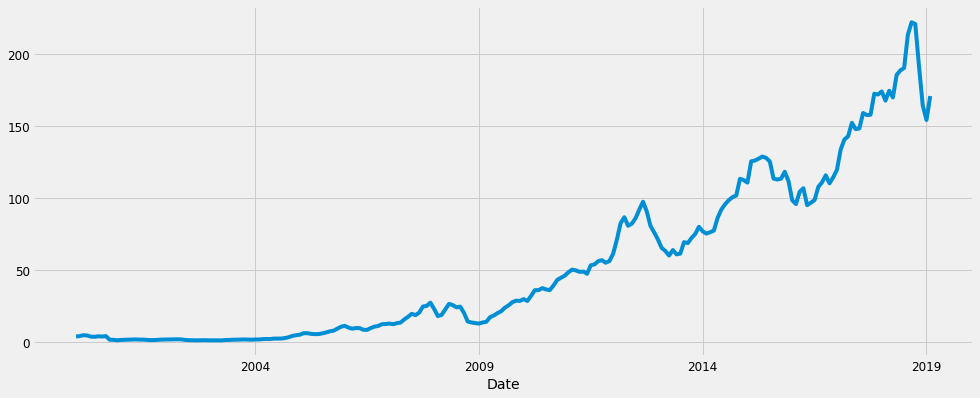

In [95]:
monthly_mean.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

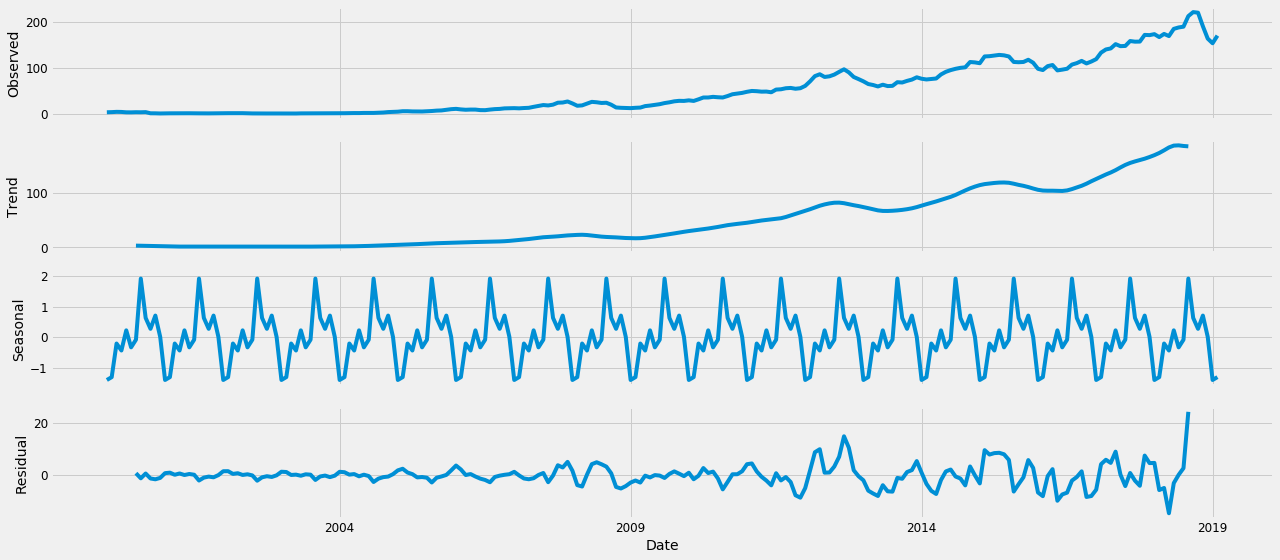

In [96]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the Close price is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:`

In [97]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [110]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2643.5019979710623
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2309.3344747851397
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1951.0204253540373
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1856.0314687281086
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1890.7953591460857
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1802.9557150994888
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1863.8878931058043
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1819.3731566966417
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2329.0358209780316
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2023.396311267176
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1696.2018573613307
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1614.3277463613813
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1665.565311522994
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1570.4018772124139
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1628.2409469481017
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1617.4495655101296
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1398.2204803534116
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1334.92167095

In [135]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [133]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3166      0.042      7.485      0.000       0.234       0.399
ar.S.L12      -0.3339      0.057     -5.863      0.000      -0.446      -0.222
ma.S.L12      -0.7985      0.059    -13.560      0.000      -0.914      -0.683
sigma2        25.9474      1.292     20.077      0.000      23.414      28.480


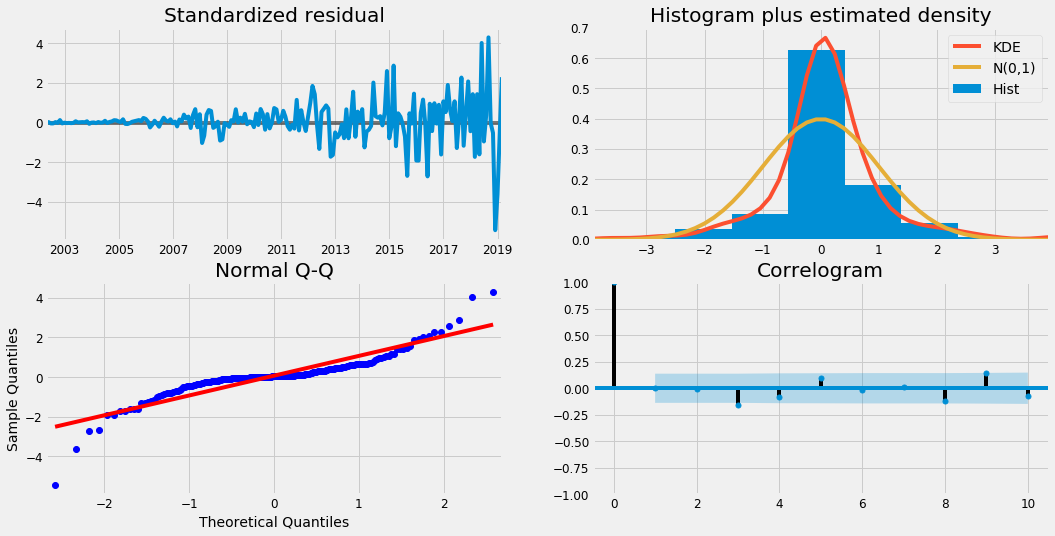

In [134]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted Close to real close price of the time series, and we set forecasts to start at `2017-12-31` to the end of the data.

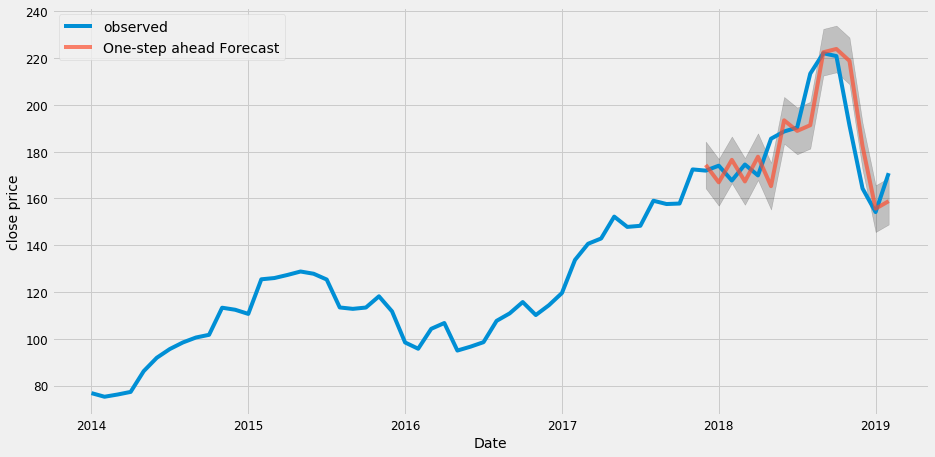

In [103]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [104]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 160.9


In [105]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 12.68


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily close price in the test set within portion... of the real close price.

## Producing and visualizing forecasts

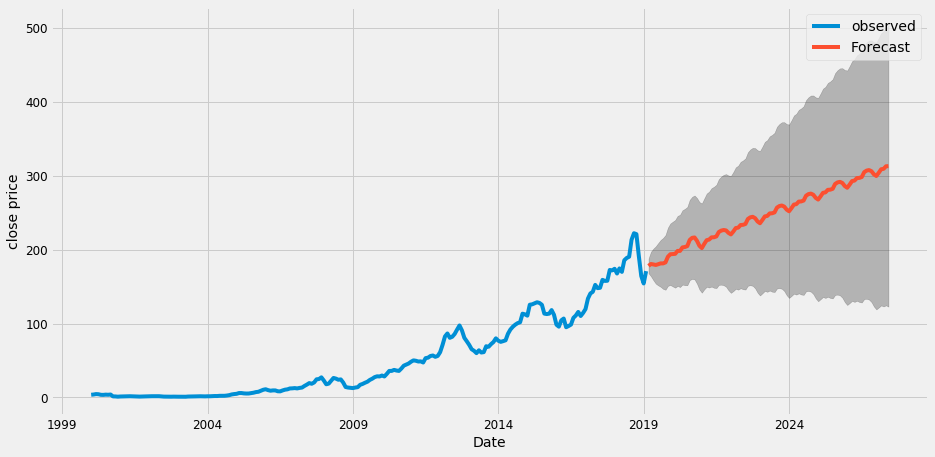

In [106]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

Our model clearly captured close price seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.